# Gold Mining

## Introduction

Machine learning prototype for Zyfra, a company who develops efficiency solutions for heavy industry. We want to predict the gold recovered from gold ore by using the data on extraction and purification. Gold recovery is a complex process involving three stages: flotation, primary filtration and secondary filtration. Each one of these stages have their own input and output characteristics regarding different metals. We will use the data from the three stages to predict the gold recovered from the ore after flotation and filtration.


## Data Preprocess

### Objective

Three dataframes were provided: one with the data to train models, one for validation and the full dataset for reference. These dataframes will be checked for errors and missing values. We will also explore what information is available and define what features will be used for training. Data available in the training data that is not present in the validation data will be removed.

### Code

In [1286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

from joblib import dump

In [1287]:
path_array = ['', '/', '/datasets/', './datasets/', '../datasets/']
CSVPATH = None

for i in path_array:
    try:
        pd.read_csv(i + 'gold_recovery_train.csv', nrows=1)
        CSVPATH = i
        break
    except:
        pass

if CSVPATH:
    print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)
else:
    print('No path found')

Path found is ../datasets/


In [1288]:
csv_names = ['train', 'test', 'full']
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', nrows=1) for sheet in csv_names}

In [1289]:
def optimize_types(df):
    df_dtypes = df.dtypes
    df_types = [i.name for i in df_dtypes.values]
    df_types = dict(zip(df.columns, df_types))
    return df_types

float_columns = df['full'].select_dtypes(include=['float64']).columns

for sheet in csv_names:
    for col in float_columns:
        if col in df[sheet]:
            df[sheet][col] = pd.to_numeric(df[sheet][col], downcast = 'float')

for sheet in csv_names:
    df_types = {sheet: optimize_types(df[sheet]) for sheet in csv_names}

In [1290]:
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', dtype=df_types[sheet], parse_dates=['date']) for sheet in csv_names}

In [1291]:
df['test'].columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [1292]:
df['train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float32
final.output.concentrate_pb                           16788 non-null float32
final.output.concentrate_sol                          16490 non-null float32
final.output.concentrate_au                           16789 non-null float32
final.output.recovery                                 15339 non-null float32
final.output.tail_ag                                  16794 non-null float32
final.output.tail_pb                                  16677 non-null float32
final.output.tail_sol                                 16715 non-null float32
final.output.tail_au                                  16794 non-null float32
primary_cleaner.input.sulfate                         15553 non-null float32
primary_cleaner.input.depressant     

In [1293]:
for sheet in csv_names:
    print('Number of duplicated rows for df ' + sheet + f': {df[sheet][df[sheet].duplicated()].shape[0]}')

Number of duplicated rows for df train: 0
Number of duplicated rows for df test: 0
Number of duplicated rows for df full: 0


In [1294]:
for sheet in csv_names:
    print('Number of missing values for df ' + sheet + f': {df[sheet].isnull().sum().sum()}')

Number of missing values for df train: 30320
Number of missing values for df test: 2360
Number of missing values for df full: 36587


In [1295]:
test_columns = df['test'].drop(['date'], axis=1).columns
train_columns = test_columns.union(['rougher.output.recovery', 'final.output.recovery'])

In [1296]:
test_train = []
for df_name in ['train', 'test']:
    full_concat = pd.concat([df['full']['date'], df[df_name]['date']], axis=0).reset_index(drop=True)
    full_concat_index = full_concat.duplicated(keep='last')
    test_train.append(df['full'].loc[full_concat_index[full_concat_index == True].index])
    
test_train[1] = test_train[1].loc[:, train_columns]
train = test_train[0]
test = test_train[1]

In [1297]:
print('Top rows with missing values in train df (%):')
(train.isna().sum()/train.shape[0]*100).sort_values(ascending=False).head()

Top rows with missing values in train df (%):


rougher.output.recovery              15.260973
rougher.output.tail_ag               13.345196
rougher.output.tail_sol              13.339265
rougher.output.tail_au               13.339265
secondary_cleaner.output.tail_sol    11.779359
dtype: float64

In [1298]:
print('Top rows with missing values in test df (%):')
(test.isna().sum()/test.shape[0]*100).sort_values(ascending=False).head()

Top rows with missing values in test df (%):


rougher.output.recovery               9.323770
final.output.recovery                 7.547814
rougher.input.floatbank11_xanthate    6.028005
primary_cleaner.input.sulfate         5.157104
primary_cleaner.input.depressant      4.849727
dtype: float64

In [1299]:
test = test.dropna().reset_index(drop=True)

print(f'Number of missing values for df test: {test.isnull().sum().sum()}')

Number of missing values for df test: 0


In [1300]:
input_bool_index = df['train'].columns.str.contains('^[a-z+._\d]+input[a-z+._\d]+')
output_bool_index = df['train'].columns.str.contains('^[a-z+._\d]+output[a-z+._\d]+')

df['train'].loc[:,input_bool_index] = (
    df['train'].loc[:, input_bool_index].dropna()
)

In [1301]:
train['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394203
std         15.096808
min          0.000000
25%         79.818375
50%         85.236000
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [1302]:
train = train.loc[train['rougher.input.feed_au'] > 0, :].reset_index(drop=True)

In [1303]:
def calc_recovery_rougher(row):
    C = row['rougher.output.concentrate_au'] # gold concentration right after flotation
    F = row['rougher.input.feed_au'] # gold concentration before flotation
    T = row['rougher.output.tail_au'] # gold in tails after flotation
    try:
        result = C * (F - T)/(F * (C - T )) * 100
    except:
        result = np.nan
    if result > 100:
        result = 100
    elif result <= 0:
        result = +0.0
    return result

In [1304]:
rougher_recovery = train.apply(calc_recovery_rougher, axis=1)
rougher_recovery.name = 'calculated_rougher_recovery'

In [1305]:
display(train[['rougher.output.recovery']].describe().merge(rougher_recovery.describe(), left_index=True, right_index=True))
print('The mean absolute error is: ', end='')
print(f"{metrics.mean_absolute_error(train['rougher.output.recovery'].fillna(0), rougher_recovery.fillna(0)):.2f}"
    )

,rougher.output.recovery,calculated_rougher_recovery
count,14287.000000,14547.000000
mean,82.394203,81.773971
std,15.096808,17.016768
min,0.000000,0.000000
25%,79.818375,79.704807
50%,85.236000,85.229911
75%,90.131691,90.203433
max,100.000000,100.000000


The mean absolute error is: 0.79


In [1306]:
train.loc[train['rougher.output.recovery'].isna(), 'rougher.output.recovery'] = rougher_recovery[train['rougher.output.recovery'].isna()]

In [1307]:
print('Percentage of missing values per column in train df:')
train.loc[:, train_columns].isna().sum().sort_values(ascending=False).head(10)/train.shape[0]

Percentage of missing values per column in train df:


rougher.output.recovery                     0.068575
rougher.input.floatbank11_xanthate          0.052119
rougher.state.floatbank10_e_air             0.034511
primary_cleaner.input.sulfate               0.026956
rougher.input.floatbank10_sulfate           0.025163
rougher.input.floatbank11_sulfate           0.024203
primary_cleaner.input.xanthate              0.020041
primary_cleaner.input.depressant            0.019145
final.output.recovery                       0.017864
secondary_cleaner.state.floatbank2_a_air    0.015367
dtype: float64

In [1308]:
train = train.iloc[train.loc[:, train_columns].dropna()['rougher.output.recovery'].notna().index]

In [1309]:
print(f'Number of missing values in feat/target columns for train df: {train.loc[:, train_columns].isna().sum().sum()}')

Number of missing values in feat/target columns for train df: 0


### Results

From the provided training dataset, we have learned that the recovery is calculated as the ratio of the total weight of the gold ore to the total weight of the gold ore after purification. That validates the calculations provided. The dataframe has been cleaned and the data is almost ready for training. We will perform exploratory data analysis to get rid of anormalities.


## Exploratory Data Analysis


### Objective


During this section, we will check data distributions and analyze some graphs regarding the data. Each graph will be used to determine if there are any outliers, because too many differences between training set and validation sets can lead to bad reuslts.


### Code

In [1310]:
train.loc[:, train_columns].corr()['rougher.output.recovery'].sort_values(ascending=False).head(10)

rougher.output.recovery                     1.000000
final.output.recovery                       0.307886
primary_cleaner.input.sulfate               0.261724
secondary_cleaner.state.floatbank4_a_air    0.226983
secondary_cleaner.state.floatbank4_b_air    0.218239
rougher.input.floatbank10_xanthate          0.208722
rougher.state.floatbank10_a_air             0.207713
rougher.input.floatbank11_xanthate          0.200332
rougher.input.feed_ag                       0.193765
rougher.input.feed_sol                      0.179417
Name: rougher.output.recovery, dtype: float64

In [1311]:
train.loc[:, train_columns].corr()['final.output.recovery'].sort_values(ascending=False).head(10)

final.output.recovery                       1.000000
primary_cleaner.input.sulfate               0.382128
rougher.input.feed_ag                       0.320859
rougher.output.recovery                     0.307886
rougher.input.floatbank10_xanthate          0.307614
rougher.input.feed_au                       0.307526
rougher.input.floatbank11_xanthate          0.302062
secondary_cleaner.state.floatbank4_a_air    0.261208
rougher.input.feed_sol                      0.247356
rougher.state.floatbank10_a_air             0.232513
Name: final.output.recovery, dtype: float64

In [1312]:
np.abs(train.loc[:, train_columns].corr()['rougher.output.recovery']).sort_values(ascending=True).head(20)

secondary_cleaner.state.floatbank3_a_level    0.000309
primary_cleaner.state.floatbank8_d_air        0.000814
primary_cleaner.input.feed_size               0.001179
secondary_cleaner.state.floatbank6_a_air      0.001383
secondary_cleaner.state.floatbank5_a_level    0.005010
primary_cleaner.state.floatbank8_d_level      0.007285
secondary_cleaner.state.floatbank2_b_level    0.008525
secondary_cleaner.state.floatbank2_a_level    0.022342
primary_cleaner.state.floatbank8_b_level      0.024756
primary_cleaner.state.floatbank8_c_level      0.027712
primary_cleaner.state.floatbank8_a_level      0.029509
primary_cleaner.input.depressant              0.030968
secondary_cleaner.state.floatbank5_b_level    0.031275
secondary_cleaner.state.floatbank3_b_level    0.033231
secondary_cleaner.state.floatbank3_b_air      0.035145
rougher.state.floatbank10_f_air               0.040862
secondary_cleaner.state.floatbank4_a_level    0.048533
rougher.input.feed_rate                       0.051587
secondary_

In [1313]:
np.abs(train.loc[:, train_columns].corr()['final.output.recovery']).sort_values(ascending=True).head(20)

secondary_cleaner.state.floatbank2_b_level    0.000898
secondary_cleaner.state.floatbank3_b_level    0.001313
secondary_cleaner.state.floatbank6_a_air      0.010000
secondary_cleaner.state.floatbank2_a_level    0.015782
primary_cleaner.state.floatbank8_d_level      0.017585
secondary_cleaner.state.floatbank3_a_level    0.023038
secondary_cleaner.state.floatbank5_a_level    0.026019
primary_cleaner.input.feed_size               0.033470
rougher.input.floatbank11_sulfate             0.033729
rougher.input.floatbank10_sulfate             0.047740
primary_cleaner.state.floatbank8_b_level      0.048019
secondary_cleaner.state.floatbank3_b_air      0.049240
secondary_cleaner.state.floatbank5_b_level    0.049805
secondary_cleaner.state.floatbank6_a_level    0.051976
primary_cleaner.state.floatbank8_a_level      0.054020
secondary_cleaner.state.floatbank4_a_level    0.054987
primary_cleaner.state.floatbank8_c_level      0.055116
primary_cleaner.state.floatbank8_d_air        0.072221
rougher.in

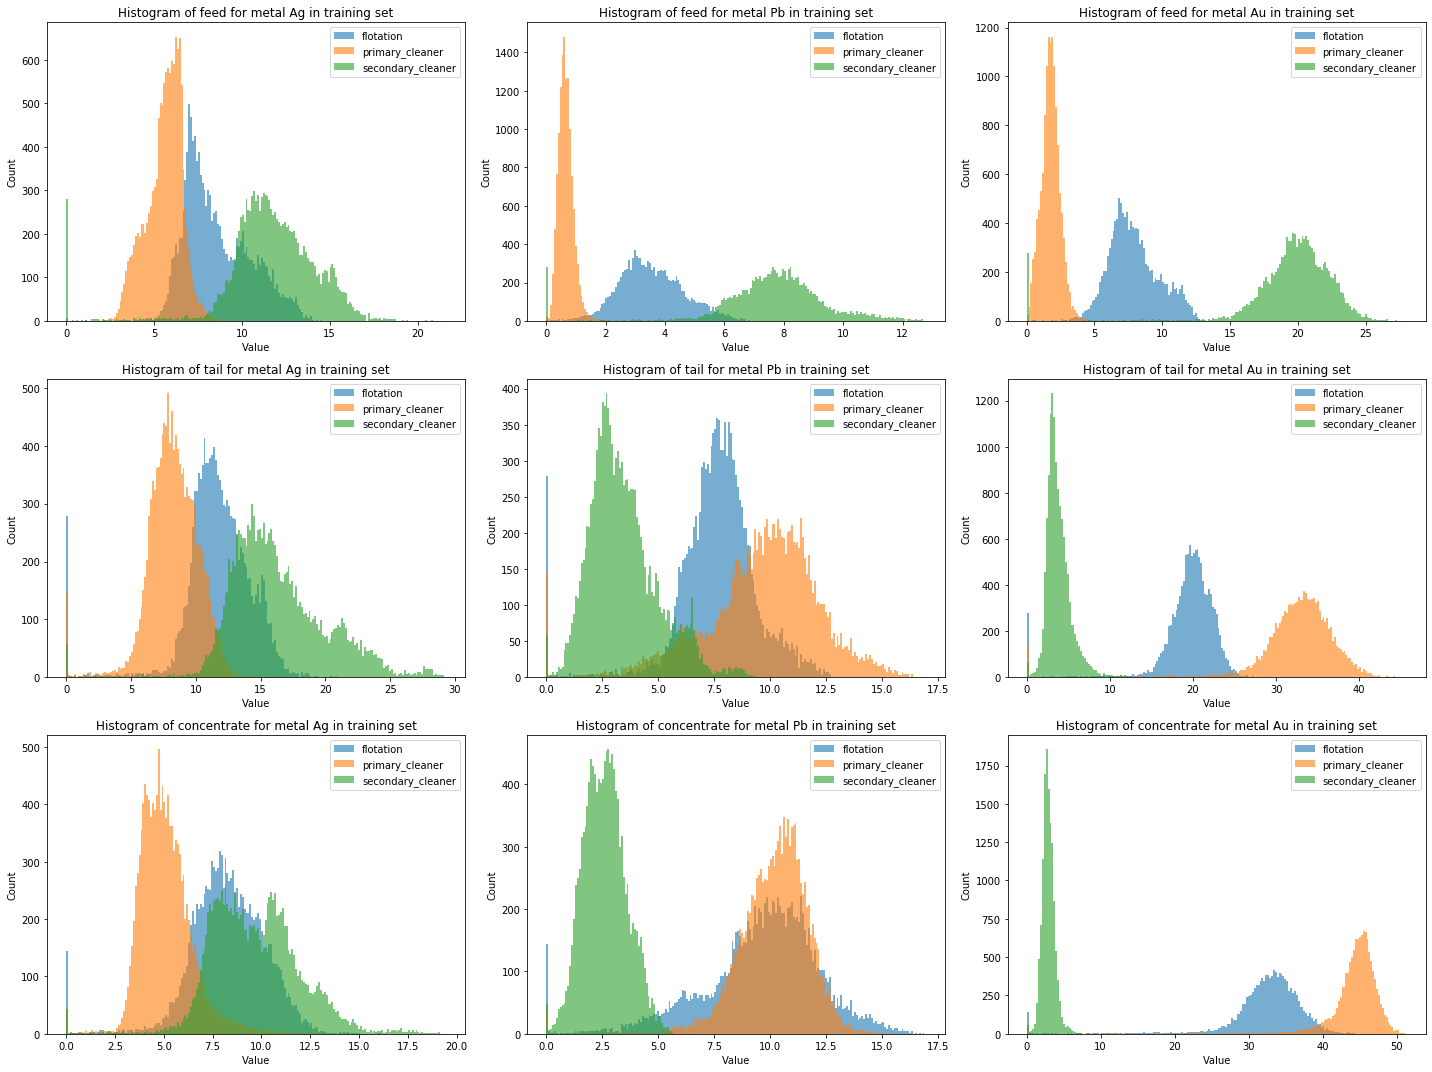

In [1314]:
fig, axs = plt.subplots(3,3, figsize=(20, 15))
fig.set_tight_layout(True)

metals = ['ag', 'pb', 'au']
stages = {
    'flotation': ['rougher.input.feed_',  'rougher.output.tail_', 'rougher.output.concentrate_'], 
    
    'primary_cleaner': ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'primary_cleaner.output.tail_'],
    
    'secondary_cleaner': ['primary_cleaner.output.concentrate_', 'final.output.concentrate_', 'final.output.tail_']
}
legend = ['flotation', 'primary_cleaner', 'secondary_cleaner']

for stage, c_i, type in zip(legend, range(len(stages)), ['feed', 'tail', 'concentrate']):
    for metal, m_i in zip(metals, range(len(metals))):
        maxrange = 0
        for col in stages[stage]:
            compare = abs(train[col + metal].max() - train[col + metal].min())
            if compare > maxrange:
                maxrange = compare
                bin_set = col
        bin = np.arange(train[bin_set + metal].min(), train[bin_set + metal].max(), maxrange/200)
        for col in stages[stage]:
            axs[c_i, m_i].hist(train[col + metal], bins=bin, alpha=0.6)
            axs[c_i, m_i].set_title('Histogram of ' + type + ' for metal ' + str.capitalize(metal) + ' in training set')
            axs[c_i, m_i].legend(legend)
            axs[c_i, m_i].set_xlabel('Value')
            axs[c_i, m_i].set_ylabel('Count')
            


plt.show()
    

*Graph Analysis*

The graphs above show the distributions of metal concentrations in the ore during flotation, primary filtration and secondary filtration. We can see that values can vary a lot from stage to stage for each metal. The main abnormalities found are zero values, specially in gold concentrations. According to the simulation, these values can generate calculation errors because of divisions by zero. We will remove these values from the data. Since the distributions are too different from each other, removing the ouliers for each plot would greatly affect the number of samples, and it is assumed that these outliers are only part of the process. The zero values will be removed, while others will be kept.

In [1315]:
for stage in stages:
    for j in metals:
        for i in range(3):
            train = train[train[stages[stage][i] + j] > 0.5]


In [1316]:
train = train[ (train['rougher.input.feed_size'] < 100) & (train['rougher.input.feed_size'] > 9) ]
test = test[ (test['rougher.input.feed_size'] < 100) & (test['rougher.input.feed_size'] > 9) ]

In [1317]:
feed_size = pd.concat([train['rougher.input.feed_size'], test['rougher.input.feed_size']], axis=1)

feed_size.describe()

,rougher.input.feed_size,rougher.input.feed_size
count,8660.000000,5147.000000
mean,56.306366,54.539562
std,10.516039,13.036544
min,9.659576,25.891541
25%,49.253212,43.873737
50%,54.332352,50.399414
75%,61.228279,61.477100
max,99.944870,99.938789


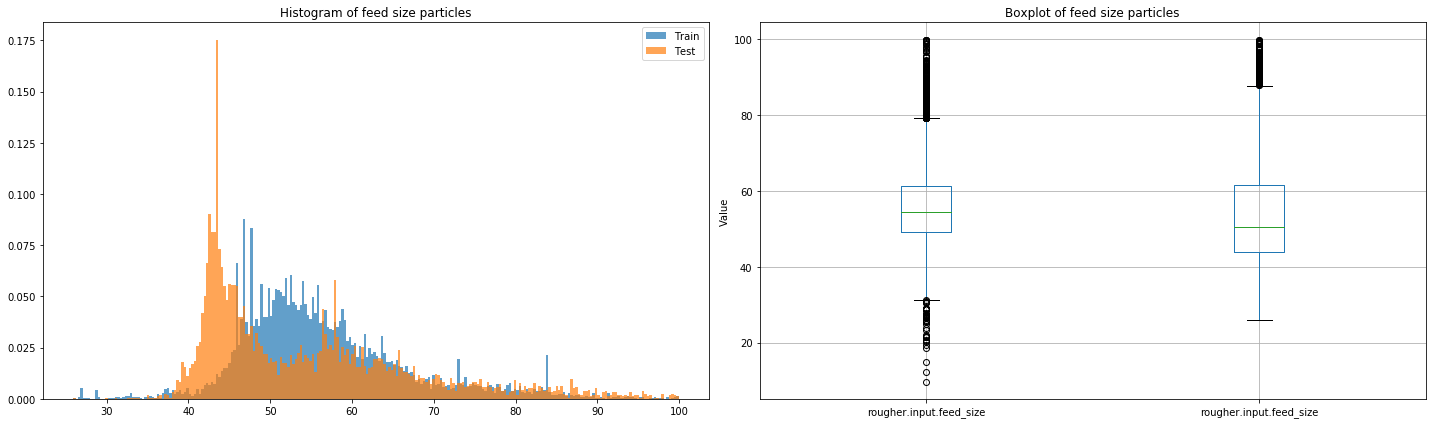

In [1318]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
fig.set_tight_layout(True)

feed_size.boxplot()
axs[1].set_title('Boxplot of feed size particles')
axs[1].set_ylabel('Value')

for dframe in [train, test]:
    compare = abs(dframe['rougher.input.feed_size'].max() - dframe['rougher.input.feed_size'].min())
    if compare > maxrange:
        maxrange = compare
        bin_set = i
bin = np.arange(dframe['rougher.input.feed_size'].min(), dframe['rougher.input.feed_size'].max(), maxrange/300)

for dframe in [train, test]:
    axs[0].hist(dframe['rougher.input.feed_size'], bins=bin, density=True, alpha=0.7)
axs[0].set_title('Histogram of feed size particles')
axs[0].legend(['Train', 'Test'])

plt.show()

*Graph Analysis*

By looking at the graph above, we can see that there are differences between the distributions of feed size. At this point, the data has been filtered through and we have remove the majority of outliers. We can still see that the feed size distributions are not the same, but are close enough to each other for the model training.

### Results

We have checked data distributions to determine if there are problems in the data regarding outliers, or distributions so different that we will train a model that will not be able to predict the data. We have also checked correlations between the features and the target variable. We can see that many of the features are not considerably correlated with the target variables. It may be possible to optimize the model by these features.

## Model Training

### Objective

After preparing the data and confirming distributions and correlations, we will train a model to predict the gold recovered from the ore. We will use the training data to train a model and evaluate the model performance with the validation set. The metric used will be the symmetric Mean Absolute Percentage Error (SMAPE). SMAPE is a metric that measures the percentage of differences between the predicted and the actual values. The SMAPE is calculated as the absolute percentage difference between the predicted and the actual values.

### Code

In [1319]:
train = train.loc[:, train_columns].reset_index(drop=True)
test = test.loc[:, train_columns].reset_index(drop=True)
print('Size of training dataset is: ' + str(train.shape[0]))
print('Size of validation dataset is ' + str(test.shape[0]))

Size of training dataset is: 8660
Size of validation dataset is 5147


In [1320]:
train = train.loc[:, train.columns.str.contains('^[a-z+._\d]+floatbank[a-z+._\d]+') == False]
test = test.loc[:, test.columns.str.contains('^[a-z+._\d]+floatbank[a-z+._\d]+') == False]

In [1321]:
def target_features(df, tar_col, remove=[]):
    target = df[tar_col]
    remove.append(tar_col)
    features = df[[x for x in df if x not in remove]]
    return target, features

In [1322]:
def smape(target, prediction):
    sum = 0.0
    for i, j in zip(target, prediction):
        parcel = abs(i - j)/(( abs(i) + abs(j) )/2)
        sum = sum + parcel
    result = sum/len(target)
    return result

smape_scorer = metrics.make_scorer(smape, greater_is_better=True)

In [1323]:
def report(target, features=None, predictions=None, model=None, predictions_proba=None, classifier=True):
    """
    Prints a report of the model's performance. If regressor, add classifier=False
    """
    flag = 0
    if model != None:
        if predictions is not None:
            warnings.warn('Both model and predictions were passed. Ignoring model.')
        else:
            if features is None:
                raise ValueError('Features must be passed if model is passed.')
            predictions = model.predict(features)
            if classifier == True:
                predictions_proba = model.predict_proba(features)
    if predictions is not None:
        if classifier == True:
            print(f'Accuracy: {metrics.accuracy_score(target,predictions):.2%}') 
            print(f'Recall: {metrics.recall_score(target,predictions):.2%}')
            print(f'Precision: {metrics.precision_score(target,predictions):.2%}')
            print(f'F1 Score: {metrics.f1_score(target,predictions):.2%}')
        elif classifier == False:
            print(f'Mean Absolute Error: {metrics.mean_absolute_error(target,predictions):.2f}')
            print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(target,predictions)):.2f}') 
            print(f'R2 Score: {metrics.r2_score(target,predictions):.2f}')
            print(f'Predictions mean value: {np.mean(predictions):.2f} (Target mean is {np.mean(target):.2f})')
            print(f'Predictions median value: {np.median(predictions):.2f} (Target median is {np.median(target):.2f})')
            print(f'Smape Score: {smape(target, predictions):.2%}')
            target = pd.Series(target).reset_index(drop=True).sort_values()
            predictions = pd.Series(predictions)
            predictions = predictions.iloc[target.index].reset_index(drop=True)
            target = target.reset_index(drop=True)
            plt.plot(predictions, label='Predicted')
            plt.plot(target, label='Actual', color='orange')
            plt.legend(['Predicted', 'Actual'])
            plt.xlabel('Sample Number')
            plt.show()
    if predictions_proba is not None:
        fpr, tpr, thresholds = metrics.roc_curve(target, predictions_proba[:,1])
        print(f'AUC-ROC: {metrics.roc_auc_score(target,predictions_proba[:,1]):.2%}')
        flag = 1
    if flag == 1:
        return fpr, tpr, thresholds, predictions
    else:
        return predictions

In [1324]:
train_target = []
train_feat = []

x, y = target_features(train, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
train_target.append(x)
train_feat.append(y)

x, y = target_features(train, 'final.output.recovery', remove=['date'])
train_target.append(x)
train_feat.append(y)

In [1325]:
valid_target = []
valid_feat = []

x, y = target_features(test, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
valid_target.append(x)
valid_feat.append(y)

x, y = target_features(test, 'final.output.recovery', remove=['date'])
valid_target.append(x)
valid_feat.append(y)

In [1326]:
valid_feat[0] = valid_feat[0].loc[:, valid_feat[0].columns.str.contains('rougher[a-z+._\d]+') == True]
train_feat[0] = train_feat[0].loc[:, train_feat[0].columns.str.contains('rougher[a-z+._\d]+') == True]

Report of linear model for 1:
Mean Absolute Error: 5.36
Root Mean Squared Error: 12.53
R2 Score: 0.06
Predictions mean value: 84.87 (Target mean is 85.21)
Predictions median value: 84.36 (Target median is 87.46)
Smape Score: 8.28%


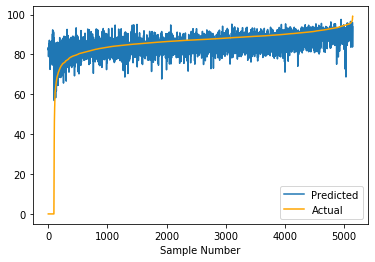



Report of linear model for 2:
Mean Absolute Error: 5.25
Root Mean Squared Error: 9.85
R2 Score: -0.28
Predictions mean value: 68.77 (Target mean is 68.68)
Predictions median value: 70.01 (Target median is 69.86)
Smape Score: 9.19%


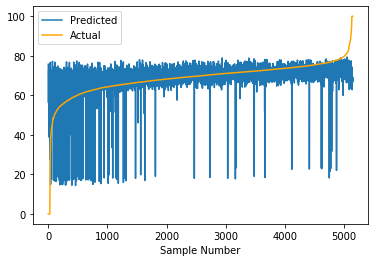



Smape of full model: 8.96%
Cross validation smape values are 
 6.37% 
 5.78% 
 6.73% 
 7.55%


In [1327]:
# Launching linear model
linear_model = []
for i in range(2):
    linear_model.append(LinearRegression(normalize=True))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of linear model for {i+1}:')
    linear_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(linear_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(linear_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75:.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


Report of tree model for 1:
Mean Absolute Error: 6.56
Root Mean Squared Error: 13.75
R2 Score: -0.13
Predictions mean value: 86.20 (Target mean is 85.21)
Predictions median value: 86.74 (Target median is 87.46)
Smape Score: 9.74%


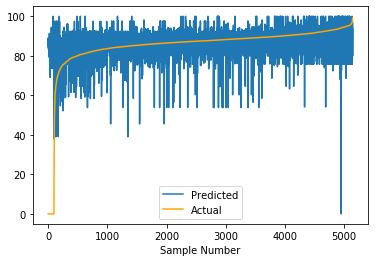



Report of tree model for 2:
Mean Absolute Error: 7.38
Root Mean Squared Error: 10.54
R2 Score: -0.46
Predictions mean value: 66.65 (Target mean is 68.68)
Predictions median value: 67.28 (Target median is 69.86)
Smape Score: 11.92%


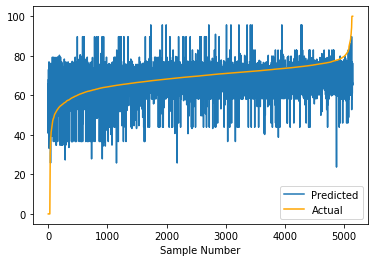



Smape of full model: 11.37%
Cross validation smape values are 
 10.43% 
 10.05% 
 9.79% 
 9.89%


In [1328]:
# Launching tree model
tree_model = []
for i in range(2):
    tree_model.append(DecisionTreeRegressor(
        random_state = 1995
    ))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of tree model for {i+1}:')
    tree_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(tree_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(tree_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75:.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


Report of forest model for 1:
Mean Absolute Error: 5.37
Root Mean Squared Error: 12.72
R2 Score: 0.03
Predictions mean value: 86.09 (Target mean is 85.21)
Predictions median value: 86.21 (Target median is 87.46)
Smape Score: 8.24%


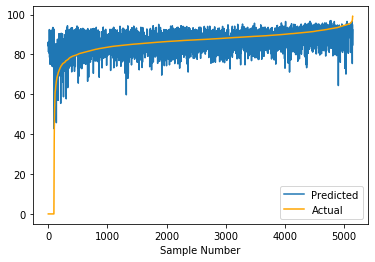

In [1329]:
# Launching forest model
forest_model = []
for i in range(2):
    forest_model.append(RandomForestRegressor(
        random_state = 1995,
        n_estimators=50
    ))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of forest model for {i+1}:')
    forest_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(forest_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(forest_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75 :.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


In [ ]:
#dump(forest_model[0], 'rougher.joblib')
#dump(forest_model[1], 'final.joblib')

OBS: Uncomment the code above to save the models

Below are the features used in the rougher model:

In [ ]:
print(train_feat[0].columns.values)

['rougher.input.feed_ag' 'rougher.input.feed_au' 'rougher.input.feed_pb'
 'rougher.input.feed_rate' 'rougher.input.feed_size'
 'rougher.input.feed_sol']


Next up are the features used in the final model:

In [ ]:
print(train_feat[1].columns.values)

['primary_cleaner.input.depressant' 'primary_cleaner.input.feed_size'
 'primary_cleaner.input.sulfate' 'primary_cleaner.input.xanthate'
 'rougher.input.feed_ag' 'rougher.input.feed_au' 'rougher.input.feed_pb'
 'rougher.input.feed_rate' 'rougher.input.feed_size'
 'rougher.input.feed_sol' 'rougher.output.recovery']


### Results

Of all trained models, the Random Forest model was the best performing. The model had a final SMAPE value of 8.45%, being cross validated with 4 models of subsets of the data. Plots comparing the target values and the predicted value were were made for each test performed. The model was trained on the full dataset. The cross validation has been done also with SMAPE scoring, and the final values obtained were between 6% and 8%. Since the floatbank information did not add up too much to the final model, this information was left out of the training and features, making the necessary input considerably easier to obtain. These models are considered our final product in this project.

## Conclusion

The data provided consisted of a training set, a test set and the full dataset. We have noticed many missing values during the data preprocessing, and the data was cleaned according to the columns available in the test set. Most of the output data was calculated after acquiring information, and specifically for the gold recovery calculation, most of it was not necessary. Although the data had information about flotation and filtration, we paid attention to not use data that would only be acquired in a posterior stage.

In this project we aimed to develop a trained model for the prediction of the gold recovered from the ore. We have used the data from the three stages of the gold recovery process to train a model, and the SMAPE metric to evaluate the model performance, obtaining a final value of 8.55%. The best performing method was the Random Forest model to train the model, and the cross validation confirmed the results. The full dataset was used to train the model.

One final remark is that floatbank information did not considerably improve the models, so that this information was not used in the training. Therefore, it will also be faster and easier to apply the model to new data. This ML model may be used to optimize efficiency and expectations of gold ore production based on identified data instead of simulations.

